# Predicción del abandono (burnout) de empleados en una empresa

## Configuraciones iniciales 

In [ ]:
# Importaciones necesarias para el desarrollo de la practica
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score

# Constantes usadas durante el desarrollo de la practica
SEED = 100475757 # La semilla es mi NIA 
employees_ava = pd.read_csv("DATA/employee_availabledata.csv")
employees_comp = pd.read_csv("DATA/employee_competition.csv")
numeric_employees_ava = employees_ava.select_dtypes(include=[np.number]) # Seleccionamos las columnas numericas


## EDA 

Antes de nada, voy a comenzar con un análisis de la database para entender mejor la estructura que sigue. Se presentan las siguientes acciones:

1. **Visualización de las primeras filas:** Para obtener una idea general de la estructura del dataset.
2. **Tipos de datos por columna:** Para identificar si las variables son categóricas, numéricas o de otro tipo.
3. **Valores nulos:** Para analizar la cantidad de valores faltantes en cada columna.
4. **Columnas con valores únicos:** Para detectar variables que tienen un solo valor en todo el conjunto de datos, lo que puede indicar redundancia.



In [47]:
# Mostrar las primeras filas del DataFrame
print("Primeras filas:")
display(employees_ava.head())

# Mostrar los tipos de datos de cada columna
print("\nTIPOS DE DATOS:")
print(employees_ava.dtypes)

# Contar los valores nulos en cada columna y mostrarlos
print("\nVALORES NULOS POR COLUMNA:")
display(employees_ava.isnull().sum())

# Encontrar columnas que solo tienen un valor único y mostrarlas
unique_columns = employees_ava.columns[employees_ava.nunique() == 1].tolist()
print("\nColumnas con valores únicos:")
print(unique_columns)

employees_ava.info() 

Primeras filas:


,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,BusinessTravel,Department,...,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,6.711397,17,2,3,3.0,3.0,4.0,45,Non-Travel,Sales,...,Y,15,8,0,10.0,3,8,5,7,No
1,6.433872,13,3,3,3.0,3.0,3.0,30,Travel_Rarely,Research & Development,...,Y,18,8,1,10.0,3,7,1,7,No
2,8.590515,15,3,3,4.0,3.0,3.0,43,Travel_Frequently,Sales,...,Y,11,8,1,10.0,5,8,4,7,No
3,6.888548,21,3,4,4.0,3.0,3.0,26,Travel_Rarely,Research & Development,...,Y,20,8,0,5.0,3,4,0,0,No
4,6.308825,11,3,3,2.0,1.0,2.0,42,Travel_Rarely,Research & Development,...,Y,11,8,0,10.0,2,0,0,0,No



TIPOS DE DATOS:
hrs                        float64
absences                     int64
JobInvolvement               int64
PerformanceRating            int64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
Age                          int64
BusinessTravel              object
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeID                   int64
Gender                      object
JobLevel                     int64
JobRole                     object
MaritalStatus               object
MonthlyIncome                int64
NumCompaniesWorked         float64
Over18                      object
PercentSalaryHike            int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears          float64
TrainingTimesLastYear        int64
YearsAtCompany               int64
Yea

hrs                         0
absences                    0
JobInvolvement              0
PerformanceRating           0
EnvironmentSatisfaction    18
JobSatisfaction            14
WorkLifeBalance            20
Age                         0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         10
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
Attrition                   0
dtype: int64


Columnas con valores únicos:
['EmployeeCount', 'Over18', 'StandardHours']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2940 entries, 0 to 2939
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hrs                      2940 non-null   float64
 1   absences                 2940 non-null   int64  
 2   JobInvolvement           2940 non-null   int64  
 3   PerformanceRating        2940 non-null   int64  
 4   EnvironmentSatisfaction  2922 non-null   float64
 5   JobSatisfaction          2926 non-null   float64
 6   WorkLifeBalance          2920 non-null   float64
 7   Age                      2940 non-null   int64  
 8   BusinessTravel           2940 non-null   object 
 9   Department               2940 non-null   object 
 10  DistanceFromHome         2940 non-null   int64  
 11  Education                2940 non-null   int64  
 12  EducationField           2940 non-null   object 
 13  Emp

Como se puede observar, existen varias columnas de la base de datos con valores nulos y algunas con un valor único en todas las filas, las cuales podrian no aportar información relevante. Además, las variables categóricas necesitarán ser codificadas en formato numérico para su correcto procesamiento. 

### Análisis de la Variable Objetivo "Attrition"

También voy a realizar un análisis de la variable objetivo "Attrition" para entender mejor su distribución en el conjunto de datos. La variable "Attrition" indica si un empleado ha dejado la empresa (yes) o no (no). Para ello, he querido realizar lo siguiente: 

1. **Contar el número de empleados en cada categoría y calcular el porcentaje correspondiente.**

2. **Mostrar un DataFrame con el conteo y el porcentaje de empleados que han dejado la empresa y los que no.**

3. **Crear un gráfico de barras para visualizar la distribución de "Attrition".**


,Count,Percentage
Attrition,,
No,2466,83.877551
Yes,474,16.122449


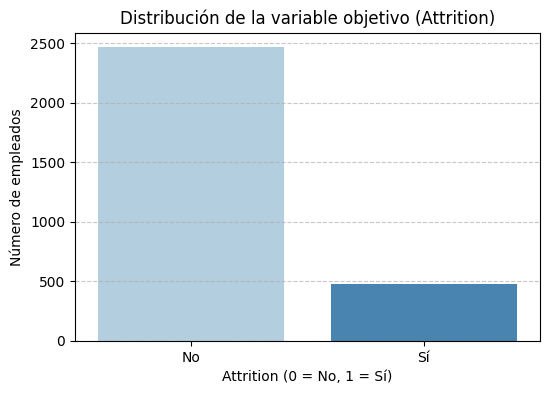

In [48]:
# Análisis de la variable objetivo "Attrition"
attrition_counts = employees_ava["Attrition"].value_counts()
attrition_percentage = employees_ava["Attrition"].value_counts(normalize=True) * 100

# Mostrar los valores y porcentajes en un DataFrame
attrition_summary = pd.DataFrame({"Count": attrition_counts, "Percentage": attrition_percentage})
display(attrition_summary)

# Visualización de la distribución de la variable objetivo
plt.figure(figsize=(6,4))
sns.barplot(x=attrition_counts.index, y=attrition_counts.values, hue=attrition_counts.index, palette="Blues")
plt.title("Distribución de la variable objetivo (Attrition)")
plt.xlabel("Attrition (0 = No, 1 = Sí)")
plt.ylabel("Número de empleados")
plt.xticks([0,1], ["No", "Sí"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Se trata de un problema de clasificación en el que la variable objetivo 'Attrition' presenta un claro desbalance, con un 83.88% de empleados que no han abandonado frente a un 16.12% que sí. Este desequilibrio podría influir en el rendimiento del modelo, favoreciendo la predicción de la clase mayoritaria y dificultando la detección de los casos de abandono.

Antes de continuar, voy a realizar una limpieza de variables, eliminando las columnas con valores únicos (Over18, EmployeeCount y StandardHours) y las que no aportan información relevante (EmployeeID). 

In [49]:
# Eliminación de las columnas con valores únicos
employees_ava = employees_ava.drop(columns=unique_columns)

# Eliminación de la columna "EmployeeID"
employees_ava = employees_ava.drop(columns="EmployeeID")

# Nueva asignación de las columnas numéricas
numeric_employees_ava = employees_ava.select_dtypes(include=[np.number])

print("Columnas eliminadas: ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeID']")
print("Columnas restantes:", employees_ava.shape[1])

Columnas eliminadas: ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeID']
Columnas restantes: 27


### Búsqueda de valores Atípicos 

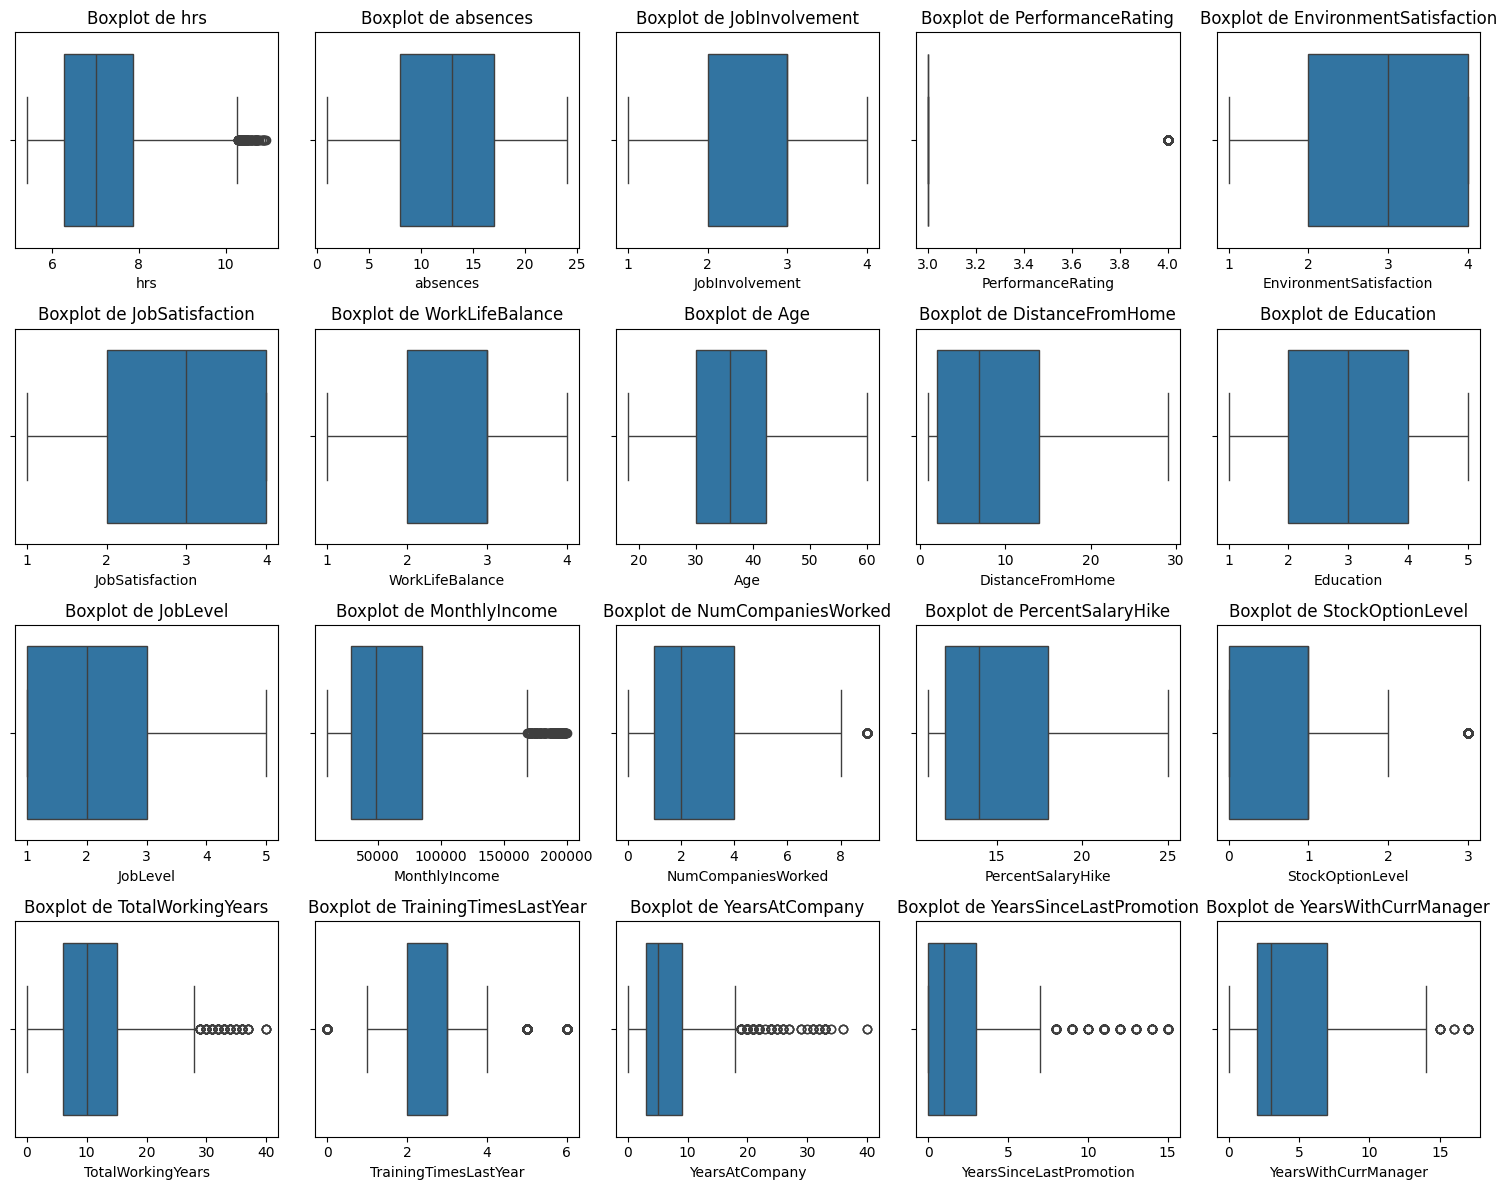

In [40]:
# Búsqueda de valores atípicos en las columnas numéricas
num_plots = len(numeric_employees_ava.columns)
num_rows = -(-num_plots // 5)  

fig, axs = plt.subplots(num_rows, 5, figsize=(15, 3*num_rows))

axs = axs.flatten() # Aplanar el array de ejes para facilitar el acceso

for i, column in enumerate(numeric_employees_ava.columns):
    sns.boxplot(x=numeric_employees_ava[column], ax=axs[i])
    axs[i].set_title(f"Boxplot de {column}")

# Ocultar ejes sobrantes
for j in range(i+1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

Como se puede observar, hay variables que cuentan con valores atípicos, ya sea porque se encuentran muy por encima o por debajo de los valores típicos como en el caso de **['hrs', 'MonthlyIncome', 'TotalWorkingYears',   'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']** o porque existe una gran mayoría de valores en un mismo número, lo que hace que el resto de valores sean considerados atípicos, aunque la diferencia no sea tan grande como en el caso anterior. Es el caso de **['PerformanceRating', 'NumCompaniesWorked', 'StockOptionLevel']**.

### Matriz de correlación general 

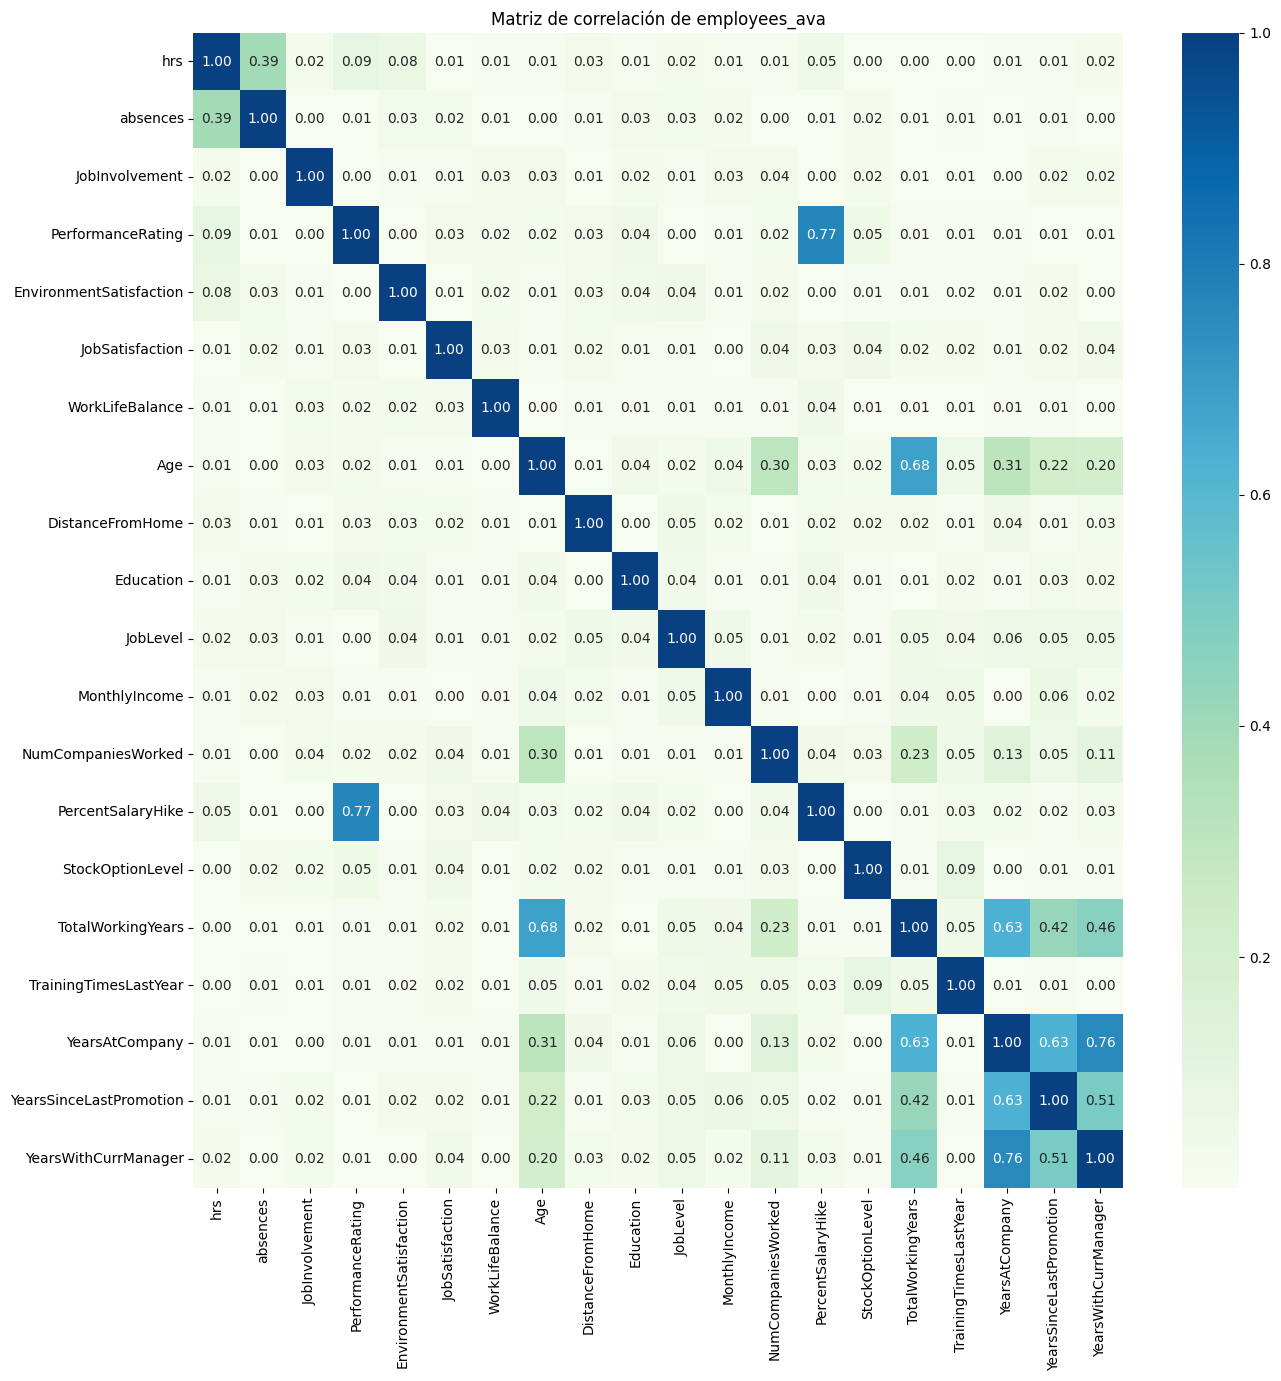

In [50]:
# Calcular la matriz de correlación de variables numéricas
correlation = numeric_employees_ava.corr()

# Poner correlaciones en valor absoluto
correlation = correlation.abs()

# Mostrar la matriz de correlación
plt.figure(figsize=(15, 15))
sns.heatmap(correlation, annot=True, cmap="GnBu", fmt=".2f")
plt.title("Matriz de correlación de employees_ava")
plt.show()

Como se puede observar, no existe una correlación muy fuerte entre las variables independientes, lo que puede indicar que aportan información relevante para el modelo. La correlación más alta se encuentra entre **'PerformanceRating'** y **'PercentSalaryHike'** con un valor de 0.77, lo que podría indicar cierta multicolinealidad entre estas variables. Además, solo se está analizando la correlación de variables numéricas, por lo tanto, no veo posible reducir la dimensionalidad del problema y voy a continuar sin eliminar ninguna variable. 

# Métodos de Evaluación
### Evaluación Outer (Estimación del rendimiento futuro)

#### Pipelines

Antes de continuar, voy a realizar el preprocesamiento y optimización de los datos, transformando las variables categóricas a numéricas a través de **OneHotEncoding**. En el caso de las columnas numéricas en las que hay valores nulos, voy a imputar la mediana de cada columna, ya que es robusta frente a valores atípicos (outliers), lo que significa que si la variable tiene datos extremos, la mediana no se verá afectada tanto como la media. Gracias a esto la imputación no distorsiona la distribución original de la variable.

In [51]:
# Convertir la variable objetivo 'Attrition' a binaria: 1 para "Yes", 0 para "No"
employees_ava['Attrition'] = employees_ava['Attrition'].map({'Yes': 1, 'No': 0})

# Separar las features y la variable objetivo
X = employees_ava.drop(columns=['Attrition'])
y = employees_ava['Attrition']

# Identificar columnas categóricas y numéricas
categorical_columns = X.select_dtypes(include=["object"]).columns.tolist()
numeric_columns = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Pipeline para transformar las variables categóricas
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Transforma variables categóricas a numéricas
])

# Pipeline para transformar las variables numéricas
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Imputa valores nulos con la mediana
    ('scaler', RobustScaler())                      # Escala las variables numéricas
])

# Combinar ambos pipelines en un ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_columns),
    ('cat', categorical_pipeline, categorical_columns)
])

# Aplicar el preprocesamiento a las features
X_preprocessed = preprocessor.fit_transform(X)

print("Forma de los datos preprocesados:", X_preprocessed.shape)

# Para revisar si se han creado las columnas correctamente
for col in categorical_columns:
    print(f"{col}: {X[col].nunique()} categorías únicas")


Forma de los datos preprocesados: (2940, 46)
BusinessTravel: 3 categorías únicas
Department: 3 categorías únicas
EducationField: 6 categorías únicas
Gender: 2 categorías únicas
JobRole: 9 categorías únicas
MaritalStatus: 3 categorías únicas


Voy a comenzar dividiendo el conjunto de datos en dos partes: un conjunto de entrenamiento (2/3 de los datos) y un conjunto de prueba (1/3 de los datos) escogidos de forma aleatoria usando como semilla mi NIA. El conjunto de entrenamiento se utilizará para ajustar el modelo, mientras que el conjunto de prueba se utilizará para evaluar su rendimiento. Además, haré uso de las métricas mencionadas en el enunciado para crear un regresor dummy y evaluarlo.

In [52]:
# Dividir los datos preprocesados en conjuntos de entrenamiento y test (2/3 train, 1/3 test)
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=1/3, random_state=SEED, stratify=y)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (1960, 46), Test: (980, 46)


### Modelo Dummy

In [55]:
# Crear y entrenar el modelo Dummy (predice siempre la clase mayoritaria)
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=SEED)
dummy_clf.fit(X_train, y_train)

# Evaluar Dummy con Cross-Validation en Train
dummy_scores = cross_val_score(dummy_clf, X_train, y_train, cv=5, scoring="balanced_accuracy")
dummy_mean_score = dummy_scores.mean()

print(f"Balanced Accuracy del modelo Dummy (Baseline en Train): {dummy_mean_score:.4f}")

# Realizar predicciones en el conjunto de test
y_pred = dummy_clf.predict(X_test)

# Evaluar el rendimiento del modelo
acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)

# Calcular la matriz de confusión
conf_mat = confusion_matrix(y_test, y_pred)

# Extraer TN, FP, FN y TP para calcular TPR (sensibilidad) y TNR (especificidad)
if conf_mat.shape == (2, 2):
    TN, FP, FN, TP = conf_mat.ravel()
    TPR = TP / (TP + FN) if (TP + FN) > 0 else np.nan  # True Positive Rate
    TNR = TN / (TN + FP) if (TN + FP) > 0 else np.nan  # True Negative Rate
else:
    TPR, TNR = np.nan, np.nan

print("Accuracy modelo dummy:", acc)
print("Balanced Accuracy modelo dummy:", bal_acc)
print("TPR (Sensibilidad) modelo dummy:", TPR)
print("TNR (Especificidad) modelo dummy:", TNR)
print("Matriz de Confusión modelo dummy:\n", conf_mat)

Balanced Accuracy del modelo Dummy (Baseline en Train): 0.5000
Accuracy modelo dummy: 0.8387755102040816
Balanced Accuracy modelo dummy: 0.5
TPR (Sensibilidad) modelo dummy: 0.0
TNR (Especificidad) modelo dummy: 1.0
Matriz de Confusión modelo dummy:
 [[822   0]
 [158   0]]


Como se puede oberservar, el modelo identifica correctamente a todos los empleados que no abandonan (TNR = 1.0) y falla completamente en detectar a aquellos que sí abandonan (TPR = 0.0). Esta situación se evidencia en la matriz de confusión, donde se observan 822 verdaderos negativos y 158 falsos negativos, sin ningún verdadero positivo. Sus métricas indican claramente que no aporta información útil para la detección de la variable objetivo 'Attrition' y por lo tanto, cumple con el objetivo de ser un modelo dummy.

### Evaluación Inner (Optimización de Hiperparámetros)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Lista de modelos a evaluar
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=SEED),
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=SEED)
}

# Evaluar cada modelo en train usando cross-validation (5 folds)
cv_results = {}

for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='balanced_accuracy')
    cv_results[model_name] = scores.mean()
    print(f"{model_name}: Balanced Accuracy promedio (CV) = {scores.mean():.4f}")


Decision Tree: Balanced Accuracy promedio (CV) = 0.8095
KNN: Balanced Accuracy promedio (CV) = 0.5842
Logistic Regression: Balanced Accuracy promedio (CV) = 0.5972
